In [7]:
import numpy as np
import matplotlib.pyplot as plt

class Environment:
    def __init__(self) -> None:
        self.current_state = 0
        self.is_terminated = False

    def reset(self):
        self.current_state = 0
        self.is_terminated = True

    def start_new_trial(self):
        self.is_terminated = False

    def get_current_state(self):
        return self.current_state

    def get_reward_for_action(self, action):
        reward_mapping = {0: [1, 2, -1], 1: [8, -8], 2: [0, 4]}
        return reward_mapping.get(self.current_state, [0])[action]

    def take_action(self, action):
        self.is_terminated = False
        reward = self.get_reward_for_action(action)
        if self.current_state == 0:
            if action < 2:
                # There is no further state if A or B is chosen
                self.reset()
            else:
                # Random transition to the left or right if C is chosen
                self.current_state = np.random.randint(1, 3)
        else:
            # There is no further state after state 1
            self.reset()
        return reward


class Agent:
    def __init__(self, environment, epsilon_actor=0.075, policy_type="random",epsilon_critic=0.2, decay=0, beta=1) -> None:
        self.values = np.zeros(3)
        self.memory = [[0, 0, 0], [0, 0], [0, 0]]
        self.policy = [[1/3, 1/3, 1/3], [0.5, 0.5], [0.5, 0.5]]
        self.environment = environment
        self.epsilon_actor = epsilon_actor
        self.epsilon_critic = epsilon_critic
        self.decay = decay
        self.beta = beta

    def reset_agent(self):
        # Reset at the start of a new epoch
        self.values = np.zeros(3)
        self.memory = [[0, 0, 0], [0, 0], [0, 0]]
        self.policy = [[1/3, 1/3, 1/3], [0.5, 0.5], [0.5, 0.5]]

    def critic(self):
        return self.values

    def update_policy(self, state, reward, new_state, action):
        if action < 2:
            delta = reward - self.values[state]
        else:
            delta = reward + self.values[new_state] - self.values[state]
        for a in range(len(self.memory[state])):
            self.memory[state][a] = (1 - self.decay) * self.memory[state][a] + self.epsilon_actor * self.delta_func(action, a) * delta
            self.policy[state] = self.softmax(self.memory[state])
        return self.policy

    def update_weights(self, reward, state, new_state):
        if new_state != 0:
            delta = reward + self.values[new_state] - self.values[state]
        else:
            delta = reward - self.values[state]

        self.values[state] += self.epsilon_critic * delta

        return self.values

    def softmax(self, x):
        for i in range(len(x)):
            x[i] = self.beta * x[i]
        return np.exp(x) / np.exp(x).sum()

    def delta_func(self, a, b):
        return a == b


# Policy evaluation for "choice" environment
trials = 1000
epochs = 1000
epsilon = 0.1

env = Environment()
agent = Agent(environment=env, epsilon_actor=epsilon, epsilon_critic=epsilon)
v_hist = np.zeros((epochs, trials, 3))

for epoch in range(epochs):
    agent.reset_agent()

    for trial in range(trials):
        for step in range(2):
            if not env.is_terminated:
                state = env.current_state
                v = agent.values
                action = np.random.choice(np.arange(3), p=agent.policy[state]) if state == 0 else np.random.choice(np.arange(2), p=agent.policy[state])
                reward = env.take_action(action)
                new_state = env.current_state
                if new_state != 0:
                    delta = reward + agent.values[new_state] - agent.values[state]
                else:
                    delta = reward - agent.values[state]

                agent.values[state] += agent.epsilon_critic * delta

        v_hist[epoch, trial] = v
        env.start_new_trial()





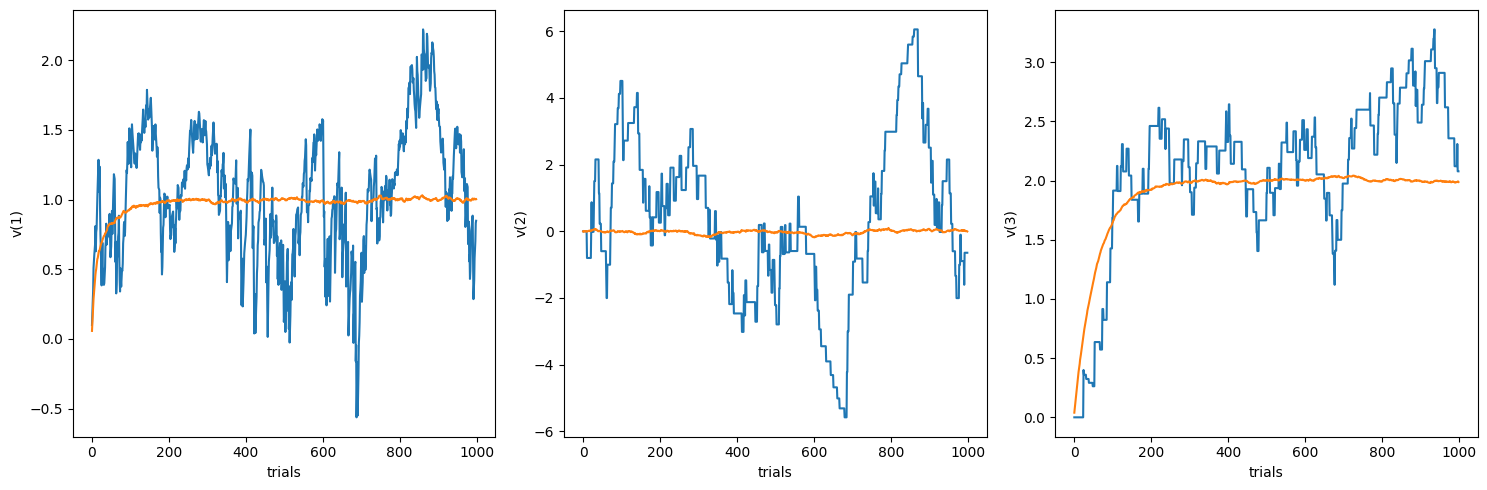

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust the figsize as needed

# Loop through each action and plot on the corresponding subplot
for action in range(3):
    means = np.mean(v_hist[:, :, action], axis=0)

    # Plot the original data
    axes[action].plot(range(epochs), v_hist[0, :, action], label=f'Action {action + 1}')

    # Plot the mean values
    axes[action].plot(range(epochs), means, label='Mean')

    # Set labels for the subplot
    axes[action].set_xlabel("trials")
    axes[action].set_ylabel(f"v({action + 1})")


# Adjust layout to prevent subplot labels from overlapping
plt.tight_layout()

# Show the plots
plt.show()

In [9]:


# Policy evaluation for "choice" environment
trials = 1000
epochs = 1000
epsilon = 0.2
epsilon_actor = 0.075
beta = 1

env = Environment()
agent = Agent(environment=env, epsilon_actor=epsilon_actor, epsilon_critic=0.2, beta=beta)
v_hist = np.zeros((epochs, trials, 3))
policy_hist = np.zeros((epochs, trials, 7))

for epoch in range(epochs):
    agent.reset_agent()

    for trial in range(trials):
        for step in range(2):
            if not env.is_terminated:
                state = env.current_state
                v = agent.values
                action = np.random.choice(np.arange(3), p=agent.policy[state]) if state == 0 else np.random.choice(np.arange(2), p=agent.policy[state])
                reward = env.take_action(action)
                new_state = env.current_state
                policy = agent.update_policy(state, reward, new_state, action)
                if new_state != 0:
                    delta = reward + agent.values[new_state] - agent.values[state]
                else:
                    delta = reward - agent.values[state]

                agent.values[state] += agent.epsilon_critic * delta

        v_hist[epoch, trial] = v
        policy_hist[epoch, trial] = np.concatenate((policy[0], policy[1], policy[2]))
        env.start_new_trial()




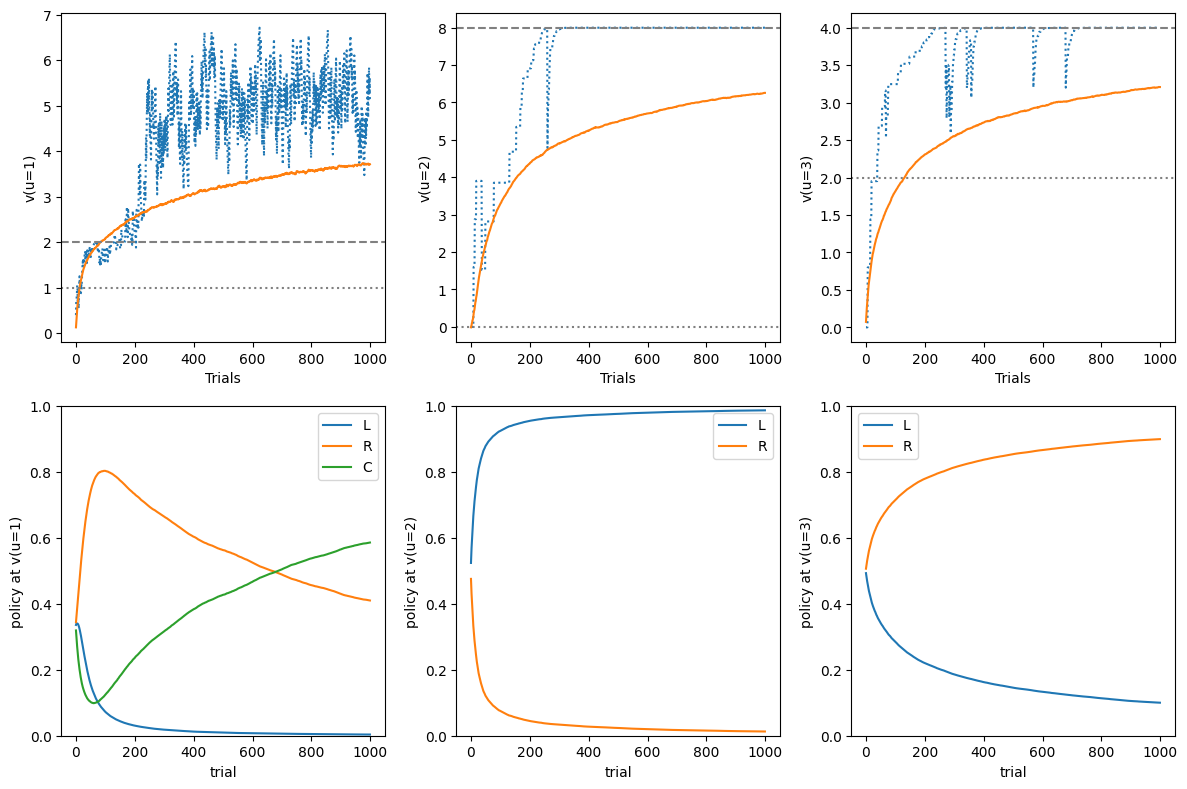

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

maxima = [2,8,4]
average_future_rewards = [1,0,2]

# Upper plots (v(u))
for action in range(3):
    means = np.mean(v_hist[:, :, action], axis=0)
    
    axs[0, action].plot(range(epochs), v_hist[0, :, action], linestyle='dotted')
    axs[0, action].plot(range(epochs), means, label="Mean")
    axs[0, action].axhline(y=maxima[action], color='grey', linestyle='dashed')  
    axs[0, action].axhline(y=average_future_rewards[action], color='grey', linestyle='dotted')

    axs[0, action].set_xlabel("Trials")
    axs[0, action].set_ylabel(f"v(u={action + 1})")

# Plot policies for v(u=1)
mean_policy_over_epochs_1 = np.mean(policy_hist[:, :, :3], axis=0)
axs[1, 0].plot(range(epochs), mean_policy_over_epochs_1[:, 0], label="L")
axs[1, 0].plot(range(epochs), mean_policy_over_epochs_1[:, 1], label="R")
axs[1, 0].plot(range(epochs), mean_policy_over_epochs_1[:, 2], label="C")
axs[1, 0].set_xlabel("trial")
axs[1, 0].set_ylabel("policy at v(u=1)")
axs[1, 0].set_ylim(0,1)
axs[1, 0].legend()

# Plot policies for v(u=2)
mean_policy_over_epochs_2 = np.mean(policy_hist[:, :, 3:5], axis=0)
axs[1, 1].plot(range(epochs), mean_policy_over_epochs_2[:, 0], label="L")
axs[1, 1].plot(range(epochs), mean_policy_over_epochs_2[:, 1], label="R")
axs[1, 1].set_xlabel("trial")
axs[1, 1].set_ylabel("policy at v(u=2)")
axs[1, 1].set_ylim(0,1)
axs[1, 1].legend()

# Plot policies for v(u=3)
mean_policy_over_epochs_3 = np.mean(policy_hist[:, :, 5:7], axis=0)
axs[1, 2].plot(range(epochs), mean_policy_over_epochs_3[:, 0], label="L")
axs[1, 2].plot(range(epochs), mean_policy_over_epochs_3[:, 1], label="R")
axs[1, 2].set_xlabel("trial")
axs[1, 2].set_ylabel("policy at v(u=3)")
axs[1, 2].set_ylim(0,1)
axs[1, 2].legend()

plt.tight_layout()
plt.show()
